In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d johnowhitaker/opencities-masked-256

 92% 306M/331M [00:02<00:00, 173MB/s]
100% 331M/331M [00:02<00:00, 164MB/s]


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
!unzip '/content/opencities-masked-256.zip'

Archive:  /content/opencities-masked-256.zip
replace mid_train/data/images-256/acc_665946_0_19_261799_253906.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.efficientnet import EfficientNetB4

import numpy as np
from sklearn.utils import shuffle

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import cv2

import os

In [9]:
image_path1='/content/mid_train/data/images-256/'
image_path2='/content/mini_train/data/images-256/'
all_image_paths = [image_path1+file for file in os.listdir(image_path1)]+[image_path2+file for file in os.listdir(image_path2)]

In [10]:
label_path1='/content/mid_train/data/masks-256/'
label_path2='/content/mini_train/data/masks-256/'
all_masks_paths=[label_path1+file for file in os.listdir(label_path1)]+[label_path2+file for file in os.listdir(label_path2)]

In [11]:
all_images_paths=sorted(all_image_paths)
all_masks_paths=sorted(all_masks_paths)

In [12]:
IMAGE_SIZE = 256

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.mean(image, axis=-1)/255.0
        images.append(image)
    return np.array(images)

In [13]:
all_images=open_images(all_images_paths)
all_masks=open_images(all_masks_paths)

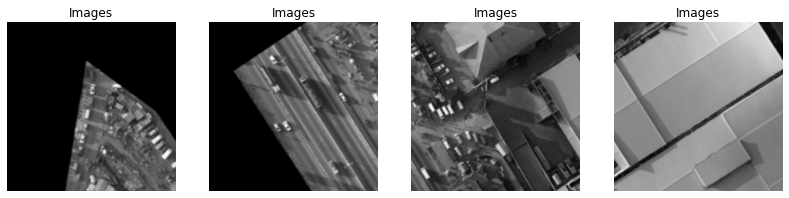

In [14]:
fig = plt.figure(figsize=(32, 32))
for i in range(1,5):
  fig.add_subplot(3,9,i)
  plt.axis('off')
  plt.title('Images')
  plt.imshow(open_images([all_images_paths[i-1]])[0], cmap='gray')
plt.show()

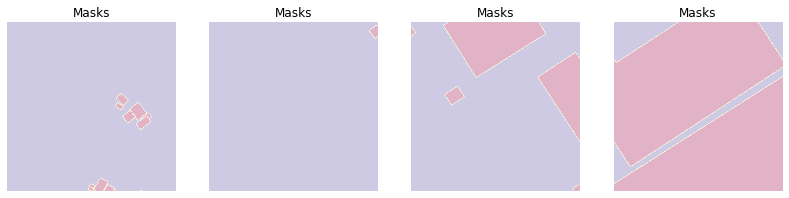

In [15]:
fig = plt.figure(figsize=(32, 32))
for i in range(1,5):
  fig.add_subplot(3,9,i)
  plt.axis('off')
  plt.title('Masks')
  plt.imshow(open_images([all_masks_paths[i-1]])[0], cmap='Spectral_r', alpha=0.3)
plt.show()

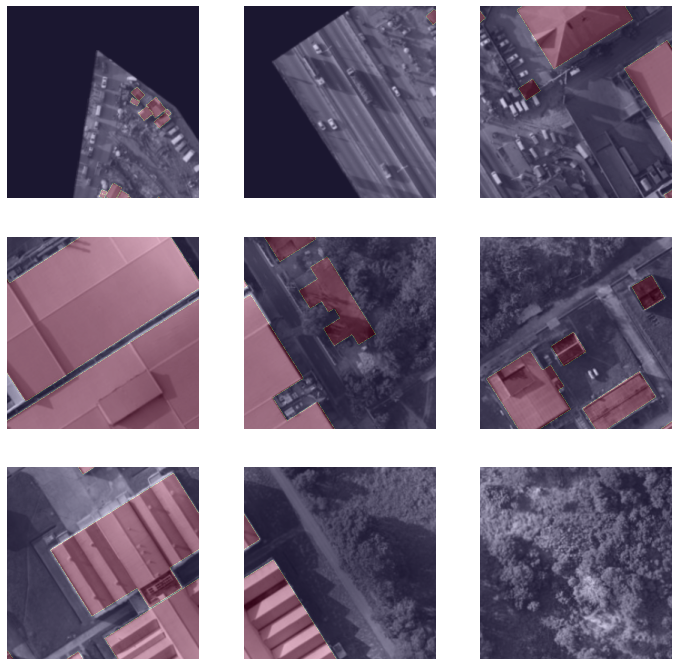

In [16]:
fig = plt.figure(figsize=(12, 12))
c = 3
r = 3
for i in range(1, c*r +1):
    fig.add_subplot(r, c, i)
    plt.axis('off')
    plt.imshow(open_images([all_images_paths[i-1]])[0], cmap='gray')
    plt.imshow(open_images([all_masks_paths[i-1]])[0], cmap='Spectral_r', alpha=0.3)
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_images,all_masks, test_size = 0.25, random_state = 0)

In [18]:
def datagen(train_img, mask_img, batch_size):
    for x in range(0, len(train_img), batch_size=16):
        images = open_images(train_img[x:x+batch_size]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
        masks = open_images(mask_img[x:x+batch_size]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
        yield images, masks

In [19]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [20]:
  tf.config.run_functions_eagerly(True)

In [21]:
inputs = Input((None, None, 1))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

from tensorflow.keras.losses import CategoricalCrossentropy
cross_entropy_loss = CategoricalCrossentropy()
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=cross_entropy_loss , metrics=[dice_coef,'accuracy'])


In [22]:
model.fit(X_train,y_train, validation_data=(X_test,y_test), batch_size=16, epochs=30)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/30
154/154 [==============================] - 29s 126ms/step - loss: 387.7729 - dice_coef: 0.3726 - accuracy: 0.7260 - val_loss: 397.3454 - val_dice_coef: 0.3699 - val_accuracy: 0.7366
Epoch 2/30
154/154 [==============================] - 18s 120ms/step - loss: 384.1975 - dice_coef: 0.3983 - accuracy: 0.7520 - val_loss: 395.2461 - val_dice_coef: 0.4066 - val_accuracy: 0.7512
Epoch 3/30
154/154 [==============================] - 19s 121ms/step - loss: 381.5515 - dice_coef: 0.4298 - accuracy: 0.7716 - val_loss: 392.8417 - val_dice_coef: 0.4003 - val_accuracy: 0.7496
Epoch 4/30
154/154 [==============================] - 18s 118ms/step - loss: 378.0340 - dice_coef: 0.4879 - accuracy: 0.8000 - val_loss: 389.0942 - val_dice_coef: 0.5009 - val_accuracy: 0.8034
Epoch 5/30
154/154 [==============================] - 18s 117ms/step - loss: 375.0049 - dice_coef: 0.5243 - accuracy: 0.8184 - val_loss: 386.2177 - val_dice_coef: 0.5658 - val_accuracy: 0.8294
Epoch 6/30
154/154 [===============

In [23]:
i=X_test
j=y_test

In [24]:
model.save('model.h5')

In [25]:
pre=model.predict((X_test))

26/26 [==============================] - 3s 80ms/step


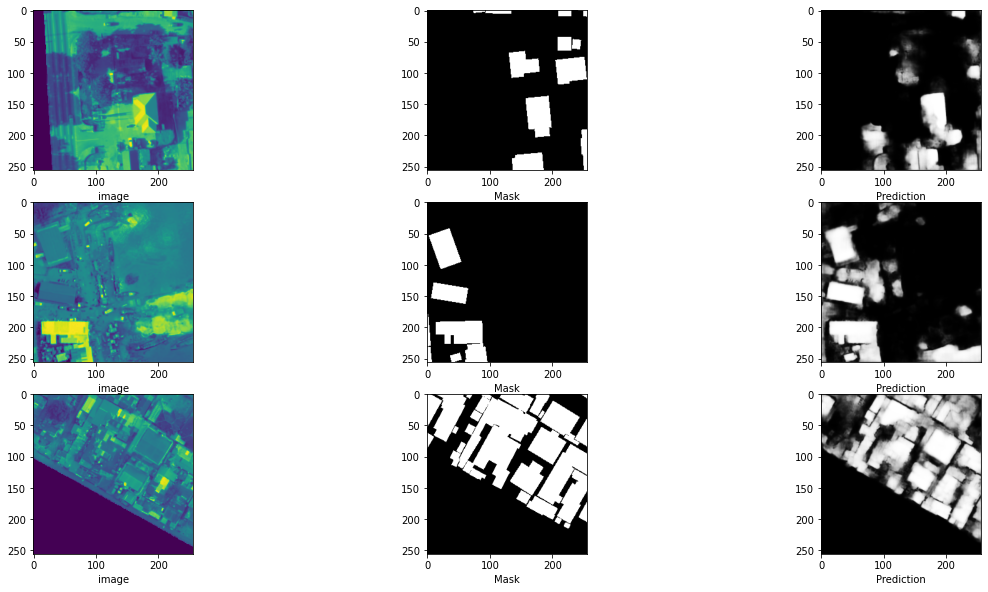

In [26]:
plt.figure(figsize=(20,10))
for x in range(0,9,3):
    plt.subplot(3,3,x+1)
    
    plt.xlabel("image")
    plt.imshow(np.squeeze(i[x]))
     
    
    plt.subplot(3,3,x+2)
    plt.xlabel("Mask")
    plt.imshow(np.squeeze(j[x]),cmap='gray')
        
    plt.subplot(3,3,x+3)
    plt.xlabel("Prediction")
    plt.imshow(np.squeeze(pre[x]),cmap='gray')